In [1]:
import os
os.chdir("..")
import anndata
import scanpy as sc
import pandas as pd
from datapre import DataProcess as DP
import pickle
import numpy as np
import scprocess

sc.set_figure_params(facecolor = "white")
sc.settings.verbosity = 3
dirname = "mouse_brain_cell2location"

d:\anaconda3\envs\scanpy\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DP.setup_seed(38)

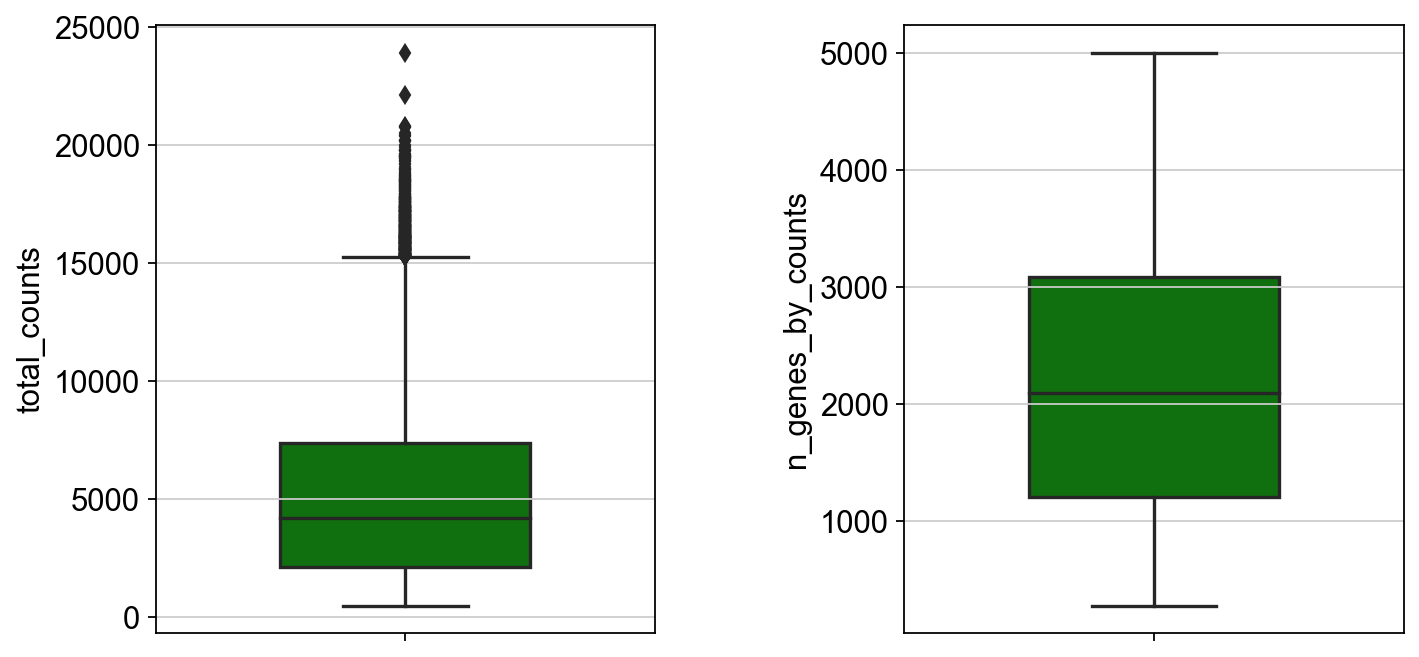

In [3]:
adata_sc = anndata.read_h5ad("data/all_cells_20200625.h5ad")
adata_sc.var_names_make_unique()
adata_sc.var["mt"] = adata_sc.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata_sc, qc_vars = ["mt"], inplace = True)
DP.FeaturePlot(adata_sc)

过滤

In [4]:
# nonz_mean_cutoff = 1.122018
# cell_count_cutoff = int(adata_sc.shape[0] * 0.0005)
# cell_count_cutoff2 = int(adata_sc.shape[0] * 0.03)
# adata_sc.var["nonz_mean"] = adata_sc.var["total_counts"] / adata_sc.var["n_cells_by_counts"]
# adata_sc = adata_sc[:, ((adata_sc.var["nonz_mean"] > nonz_mean_cutoff)
#                     & (adata_sc.var["n_cells_by_counts"] > cell_count_cutoff))
#                     | (adata_sc.var["n_cells_by_counts"] > cell_count_cutoff2)].copy()

In [5]:
sc.pp.filter_genes(adata_sc, min_counts = 10)

filtered out 7737 genes that are detected in less than 10 counts


细胞分群

In [6]:
labels = pd.read_csv("data/snRNA_annotation_astro_subtypes_refined59_20200823.csv", index_col = 0)
labels = labels.reindex(index = adata_sc.obs_names)
adata_sc.obs["clusters"] = labels["annotation_1"]
adata_sc = adata_sc[~adata_sc.obs["clusters"].isna(), :]

In [7]:
female_index = ["5705STDY8058280", "5705STDY8058281", "5705STDY8058282"]
adata_sc = adata_sc[adata_sc.obs["sample"].isin(female_index), ].copy()

In [8]:
varnames = pd.read_csv(dirname + "/adata.txt", sep = "\t", index_col = 0)
spagene = varnames["gene_ids"].values
adata_sc = DP.data_final(adata_sc, spagene = spagene)
count = adata_sc.to_df().values

normalizing counts per cell
    finished (0:00:00)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [9]:
feature_index, pair_cluster = scprocess.CreatePair(adata_sc)
with open(dirname + "/data.pkl", "rb") as myfile:
    model = pickle.load(myfile)
pred_result = scprocess.batch_predict(feature_index, count, model)
positive_mat, total_mat, mean_mat = scprocess.cluster_distance(adata_sc, pred_result, pair_cluster)

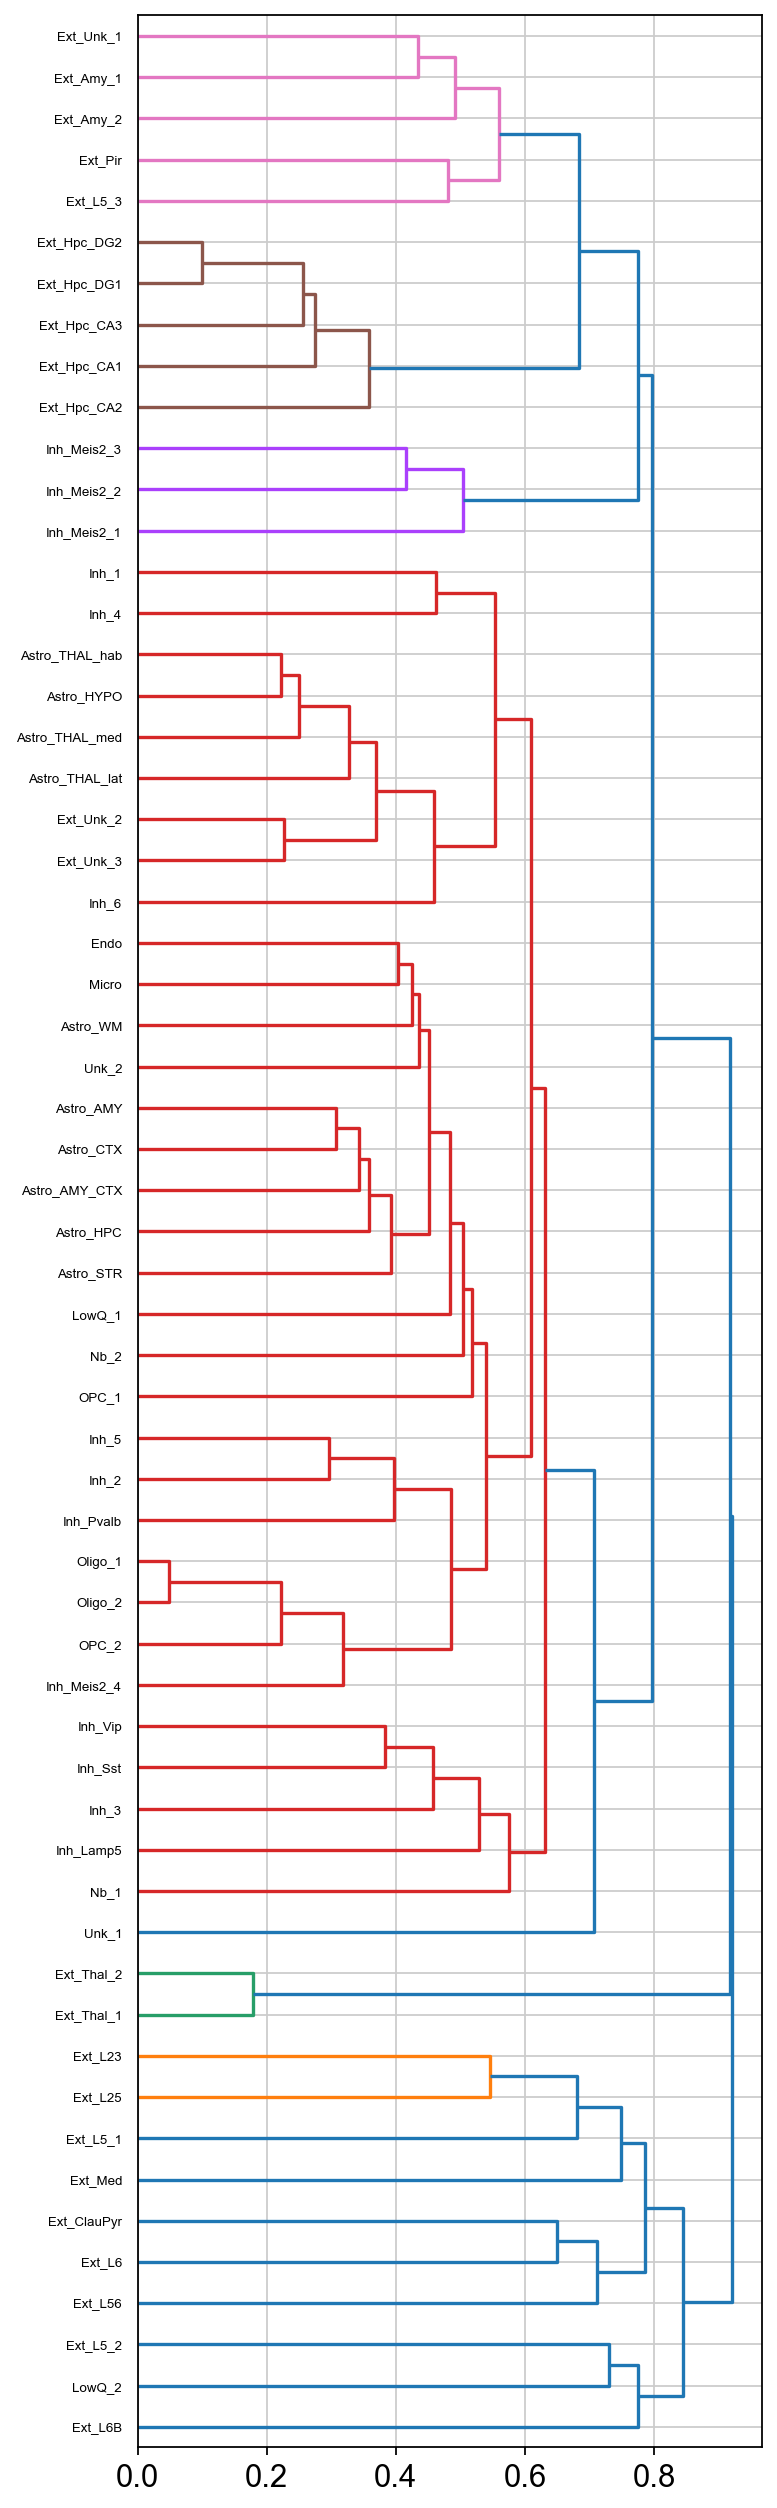

In [10]:
scprocess.cluster(mean_mat, "right", dirname)

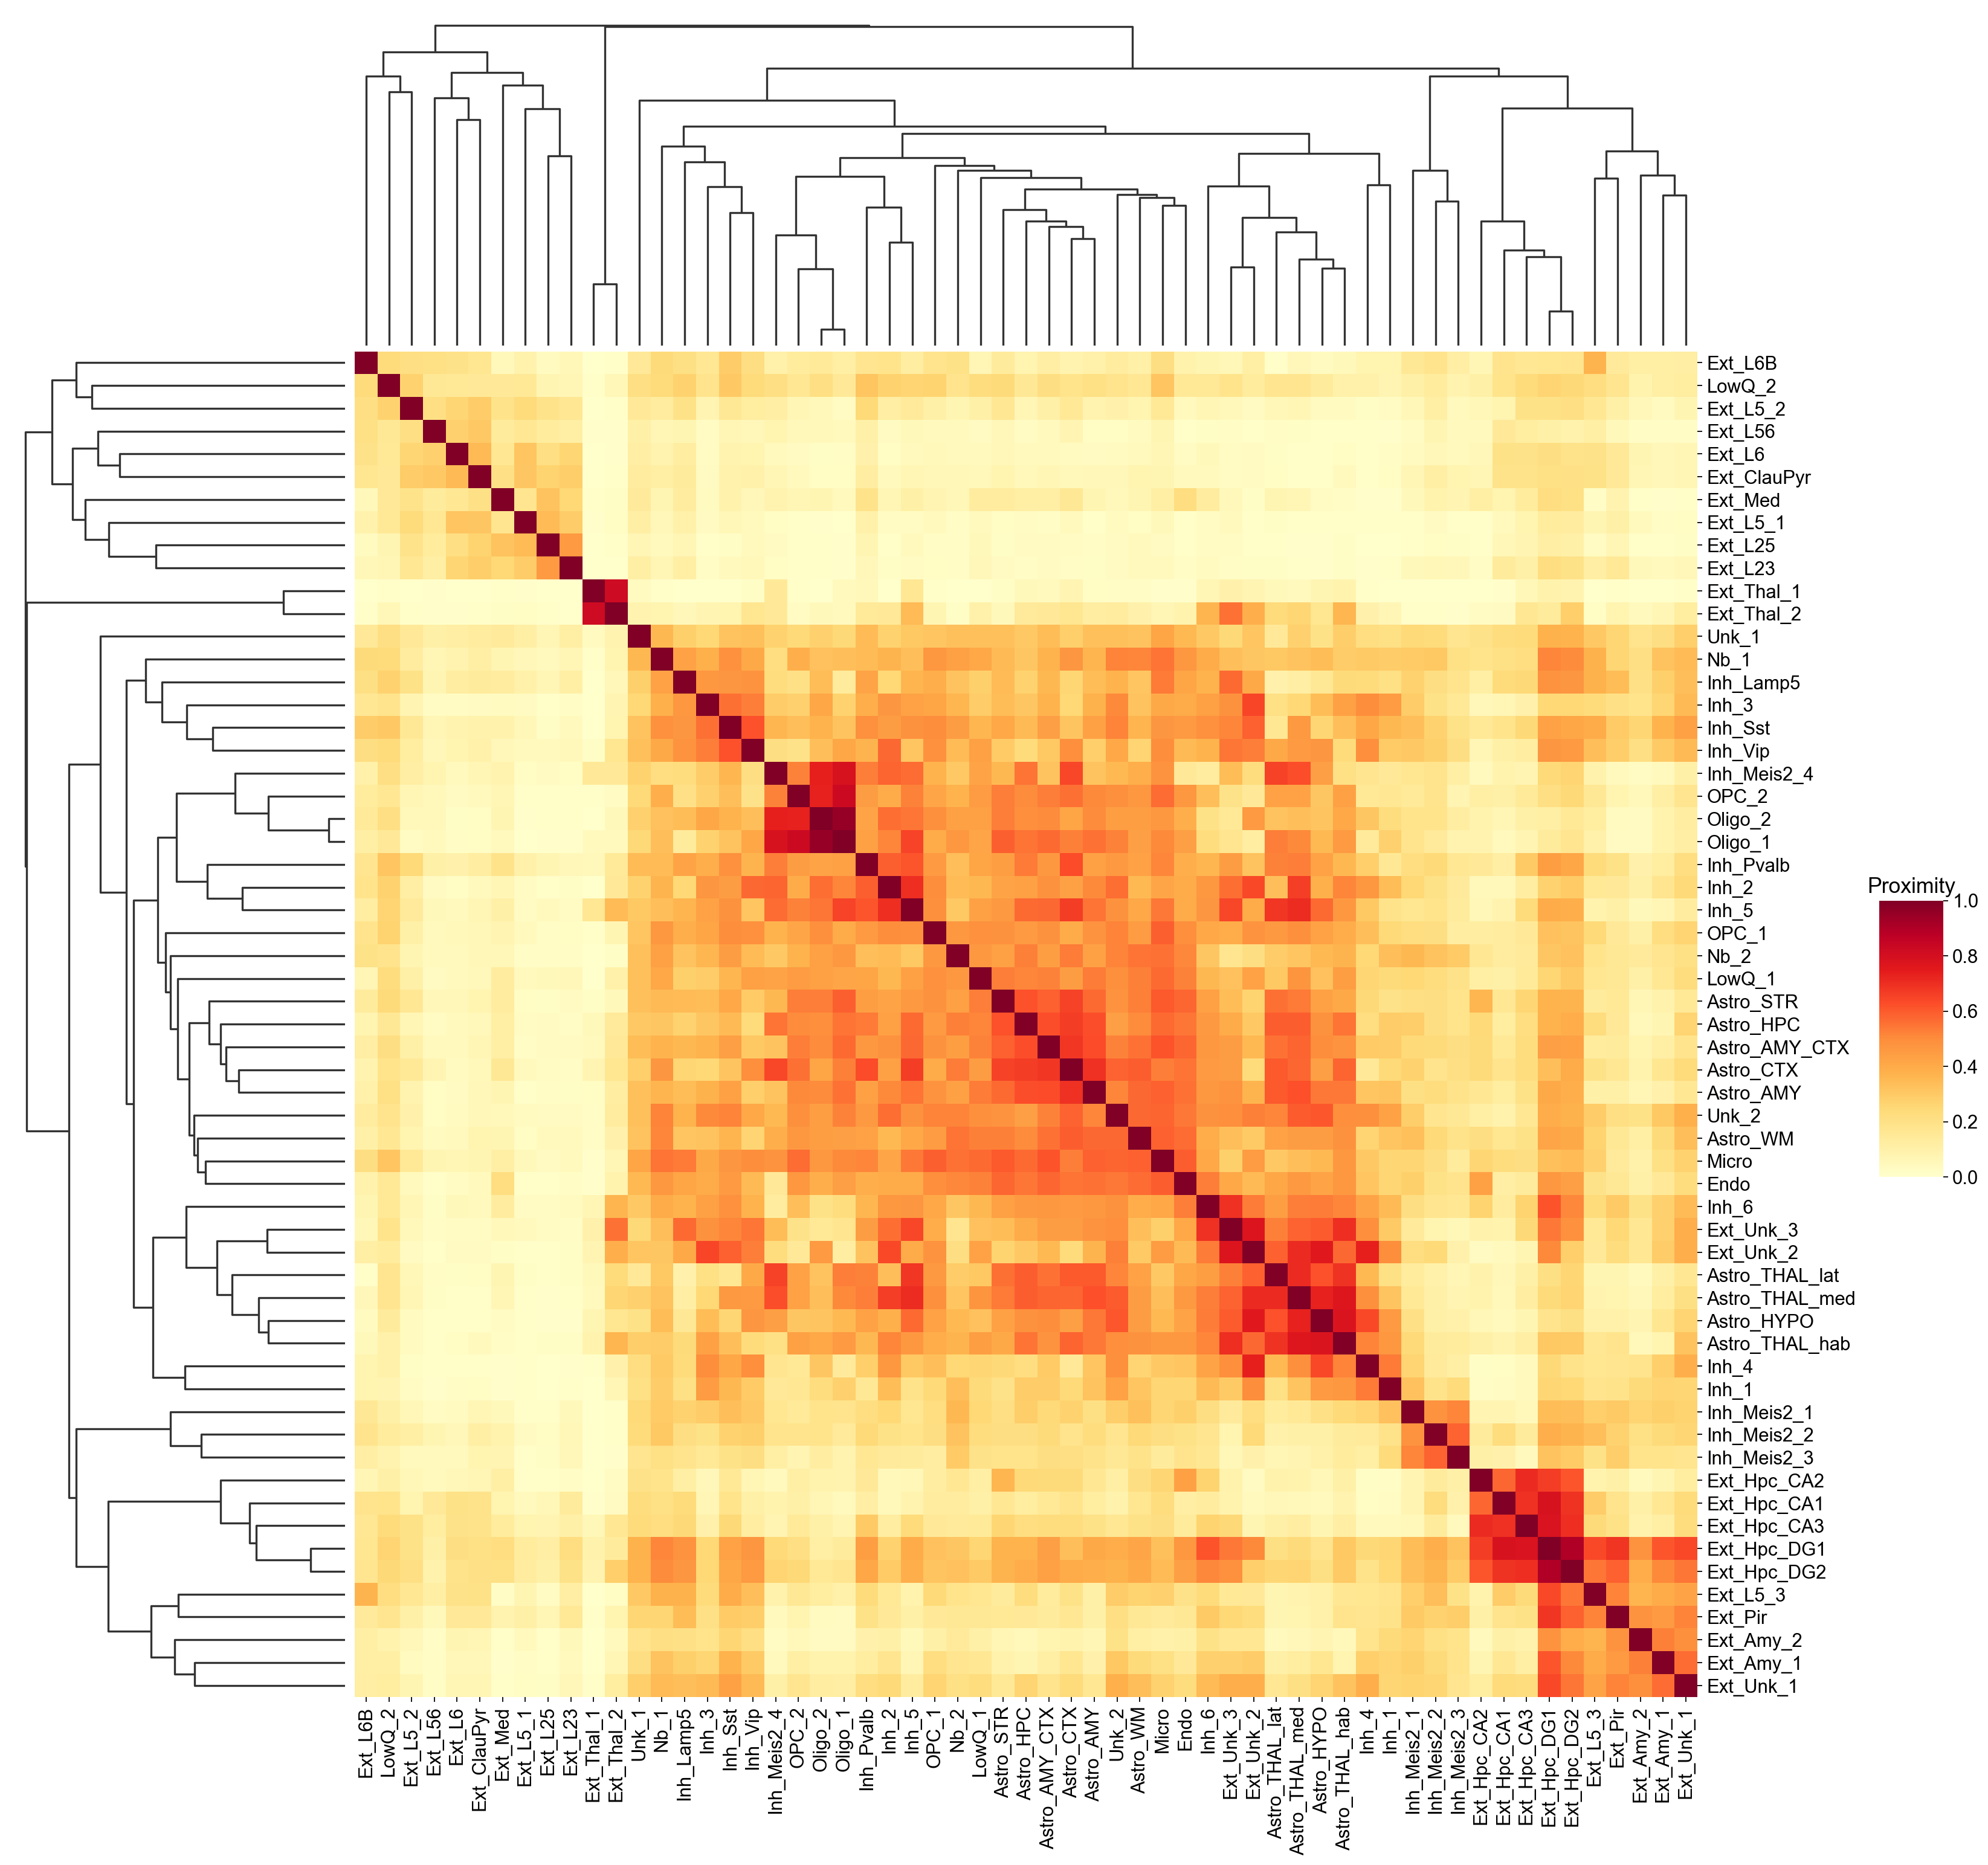

In [53]:
scprocess.clustermap(mean_mat, (22, 22), dirname)